# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [6]:
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
while True:
    action = np.random.randint(action_size)        # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    if done:                                       # exit loop if episode finished
        break
    
print("Score: {}".format(score))

Score: 2.0


When finished, you can close the environment.

In [6]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
Initializing hyper parameters 

In [6]:
import random
from collections import deque
import os
import time
import torch
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

from unityagents import UnityEnvironment
import numpy as np
from Agent import Agent
from ReplayBuffer import ReplayBuffer

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network


n_episodes = 2000       # episodes
max_t = 1000            # max time step per episode
eps_start = 1.0         # epsilon
eps_end = 0.01          # min epsilon
eps_decay = 0.995       # decay rate
seed=0                  # seed


### 5.  Setting an Environment 

Setting a default device as CPU. Loading a unity banana environment which is available for diffrent OS as mentioned in Step 1.

`UnityEnvironment`- the main interface between the Unity application and your code. Use UnityEnvironment to start and control a simulation or training session.

`BrainInfo`- contains all the data from agents in the simulation, such as observations and rewards.

`BrainParameters`- describes the data elements in a BrainInfo object. For example, provides the array length of an observation in BrainInfo.

As we are woring on one simulation, we will use first `env.brain_names[0]` brain to hold the `BrainInfo`.

Lets get 
    `action_size`
    and
    `state_size`


In [9]:


#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("device : {}".format(device))

#load unity environment. it wiil open an unity env window
env = UnityEnvironment(file_name="./Banana_Windows_x86_64/Banana.exe")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of actions
action_size = brain.vector_action_space_size

# examine the state space
state = env_info.vector_observations[0]
state_size = len(state)


device : cpu


OSError: handle is closed

Create a Replay Memory `ReplayBuffer` for our agent which will be passed as a parameter. 

We will store `100` recent socres with the hlep of queue

In [21]:
def train(agent,checkpoint_name):
    

    scores = []  # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    avg_scores = []
    eps = eps_start  # initialize epsilon

    for i_episode in range(1, n_episodes + 1):
        
        # Reset the env and set it to Train mode
        env_info = env.reset(train_mode=True)[brain_name]
        
        # Current state
        state = env_info.vector_observations[0]
        
        # Restting the score
        score = 0
        
        # loop with max step per episode
        for t in range(max_t):
            
            # Get action from agent
            action = agent.act(state, eps)
            
            # apply action on environment 
            env_info = env.step(action.astype(int))[brain_name]
            
            # get the next_state, reward and done
            next_state = env_info.vector_observations[0]  
            reward = env_info.rewards[0]  
            done = env_info.local_done[0]
            
            # Update the agent 
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            
        
            if done:
                break
                
        scores_window.append(score)  # save most recent score
        scores.append(score)  # save most recent score
        avg_scores.append(np.mean(scores_window))
        eps = max(eps_end, eps_decay * eps)  # decrease epsilon
        
    
        fig = plt.figure()
        ax = fig.add_subplot(111)
        display.clear_output(wait=True)
        plt.plot(np.arange(len(scores)), scores, label="score")
        plt.plot(np.arange(len(avg_scores)), avg_scores, label="avg score")
        plt.ylabel('Score')
        plt.xlabel('Episode #')
        plt.legend()
        plt.show()
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 13.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode - 100 ,
                                                                                        np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), checkpoint_name)
            break



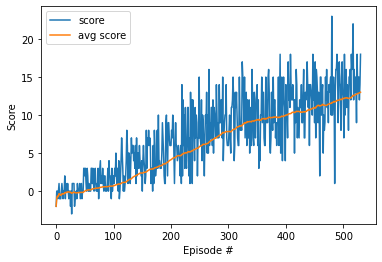

Episode 531	Average Score: 13.01
Environment solved in 431 episodes!	Average Score: 13.01


In [22]:
# Replay Buffer
memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random.seed(seed), device)
# Creating an Agnet 
agent = Agent(state_size,
              action_size,
              seed=seed,
              lr=LR,
              memory=memory,
              update_every=UPDATE_EVERY,
              batch_size=BATCH_SIZE,
              gamma=GAMMA,
              TAU=TAU ,
              device=device,DDQN=False)
train(agent,"checkpoint_dqn.pth")

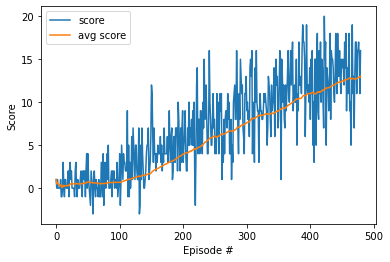

Episode 480	Average Score: 13.01
Environment solved in 380 episodes!	Average Score: 13.01


In [23]:
# Replay Buffer
memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random.seed(seed), device)
# Creating an Agnet 
agent = Agent(state_size,
              action_size,
              seed=seed,
              lr=LR,
              memory=memory,
              update_every=UPDATE_EVERY,
              batch_size=BATCH_SIZE,
              gamma=GAMMA,
              TAU=TAU ,
              device=device,DDQN=True)
train(agent,"checkpoint_ddqn.pth")

### 7. Evaluate the train agent 
Load the `qnetwork_local` weights from `checkpoint.pth`. 

Resetting the env with `train_mode=False`. We will run for `10` episodes. Added `time.sleep(0.03)` wait time to make it visible how agent performs.

In [10]:
# Replay Buffer
memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random.seed(seed), device)
# Creating an Agnet 
agent = Agent(state_size,
              action_size,
              seed=seed,
              lr=LR,
              memory=memory,
              update_every=UPDATE_EVERY,
              batch_size=BATCH_SIZE,
              gamma=GAMMA,
              TAU=TAU ,
              device=device,DDQN=True)

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=False)[brain_name]
agent.qnetwork_local.load_state_dict(torch.load('checkpoint_ddqn.pth'))
agent.qnetwork_local.eval()

env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations[0]
score = 0

while True:
    #state = env.reset()
    action = agent.act(state)
    env_info = env.step(action.astype(int))[brain_name]
    next_state = env_info.vector_observations[0]  # get the next state
    reward = env_info.rewards[0]  # get the reward
    done = env_info.local_done[0]
    state = next_state
    score += reward
    if done:
        break
    
    print('\rScore: {:.2f}'.format(score), end="")
    env.close()
    

UnityEnvironmentException: No Unity environment is loaded.